### imports

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill
import datetime

import shap
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import shap_flow_util
from shap_flow_util import (
    read_csv_incl_timeindex,
    get_mean_shap_attr,
    plot_dependency, 
    read_csv_incl_timeindex, 
    rename_nodes_in_graph_paper, 
    rename_target_node_paper,
    save_graph_paper, 
    plot_bar_mean_abs_asv,
    plot_bar_mean_abs_shap,
    get_color 
)

# load credit flow, models, etc.

In [82]:
# load credit flow and models from file
periods = [('2018-01-01', '2021-09-30'),
            ('2021-10-01', '2023-12-31'),
            ('2018-01-01', '2023-12-31')]
version = 'v2'
date = datetime.datetime.now().strftime("%Y-%m-%d")
target= 'export' # 'price' or 'export'
rename_dict = shap_flow_util.paper_rename_dict

creditflow_list = []
model_list = []
fg_list = []
bg_list = []
for (start_date, end_date) in periods:
    cf_file_name = 'flow_xgb_{}_start_{}_end_{}'.format(target, start_date, end_date, version)
    with open('./credit_flow/{}/{}.pkl'.format(version, cf_file_name), 'rb') as file:
        loaded_cf = dill.load(file)
        rename_nodes_in_graph_paper(cf=loaded_cf)
        rename_target_node_paper(cf=loaded_cf, target=target)
        creditflow_list.append(loaded_cf)

    model = xgb.Booster()
    model_name = 'xgb_{}_start_{}_end_{}_best'.format(target, start_date, end_date)
    model.load_model("./models/{}/{}.json".format(version, model_name))
    model_list.append(model)
    fg_list.append(read_csv_incl_timeindex('./data/{}/fg_xgb_{}_start_{}_end_{}.csv'.format(version, target, start_date, end_date)).rename(rename_dict, axis=1))
    bg_list.append(read_csv_incl_timeindex('./data/{}/bg_xgb_{}_start_{}_end_{}.csv'.format(version, target, start_date, end_date)).rename(rename_dict, axis=1))

# Shapley flow

## Plots of mean absolute credit

### Mean absolute edge credit

In [ ]:
max_display = 25
for model_index in range(3):
    creditflow_list[model_index].fold_noise=True
    g = creditflow_list[model_index].draw(idx=-1,
                    show_fg_val=True,
                    max_display=max_display)
    start_date, end_date = periods[model_index]
    g.graph_attr['rankdir']='LR' # change layout from top-bottom to left-right
    save_graph_paper(g, './plots/{}/{}_{}_flow_mean-abs_show-{}_{}_{}'.format(version, model_index, target, max_display, start_date, end_date), target=target, format='pdf', view=False)

### Mean absolute ASV

In [ ]:
for i, period in enumerate(periods):
    start, end = period 
    plot_bar_mean_abs_asv(creditflow_list[i], figsize=(6, 7), save=True, name='{}_{}_{}'.format(target, start, end), target=target)

### Mean absolute SHAP (direct impact)

In [ ]:
for i, period in enumerate(periods):
    start, end = period 
    if target=='price':
        target_l = 'Price FR'
    else:
        target_l = 'Net exports FR'
    plot_bar_mean_abs_shap(creditflow_list[i], target_l=target_l, figsize=(6, 7), save=True, name='{}_{}_{}'.format(target, start, end), target=target)

### Compare SHAP for different models

In [86]:
df_feature_attr = pd.DataFrame()
for i, period in enumerate(periods):
    start, end = period
    col_name = 'XGB' + start + ' to ' + end
    df_feature_attr[col_name] = get_mean_shap_attr(creditflow_list[i], target_l)
    df_feature_attr[col_name] = df_feature_attr[col_name]/df_feature_attr[col_name].max()

new_order = [
    'Day of year (sin)', 'Day of year (cos)', 'Hour (sin)', 'Hour (cos)', 'Is Working Day?',
    'Nuclear availability',
    'Carbon price',
    'Gas price',
    'Solar day-ahead',
    'Load day-ahead FR', 
    'Wind day-ahead',

    'RL BE',
    'RL DE-LU',
    'RL ES',
    'RL IT-North',
    'RL ramp FR',

    'Air temperature',
    'River temperature',
    'River flow rate',
    'ROR generation']

# Reindex the DataFrame
df_feature_attr = df_feature_attr.reindex(new_order)

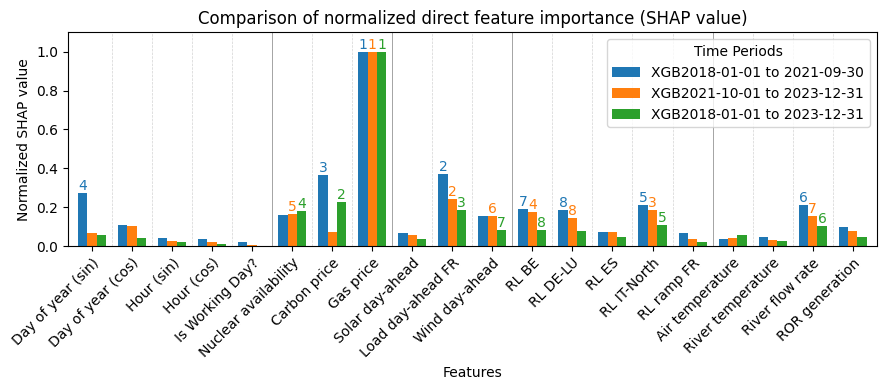

In [87]:
ax = df_feature_attr.plot(kind='bar', figsize=(9, 4), width=0.7)

plt.title("Comparison of normalized direct feature importance (SHAP value)")
plt.xlabel("Features")
plt.ylabel("Normalized SHAP value")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.legend(title="Time Periods")
#ax.legend().remove()
plt.tight_layout()


ax.set_ylim(0, 1.1)

num_features = 8

for period in df_feature_attr.columns:
    top_features = df_feature_attr.nlargest(num_features, period)

    for feature_name in top_features.index:
        bar_index = list(df_feature_attr.index).index(feature_name)
        height = df_feature_attr.at[feature_name, period]
        feature_rank = top_features.index.get_loc(feature_name) + 1

        for container in ax.containers:
            if container.get_label() == period:
                bar = container[bar_index]
                bar_color = bar.get_facecolor()
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), feature_rank, 
                        color=bar_color, ha='center', va='bottom', rotation=0, rotation_mode='anchor')

for i in range(len(df_feature_attr.index) - 1):
    if i in [4, 7, 10, 15]:
        plt.axvline(x=i + 0.5, color='grey', linestyle='-', linewidth=0.5)
    else:
        plt.axvline(x=i + 0.5, color='lightgrey', linestyle='--', linewidth=0.5)

plt.savefig("./plots/{}/normalized_shap_feature_importance_{}.pdf".format(version, target), dpi=300, bbox_inches='tight')
plt.show()

## Dependency plot

In [88]:
fig_size = (6, 3.4)
def plot_dependency_all(target, cf, fg, file_name):
    common_args = {
        'cf': cf,
        'fg_values': fg,
        'save': True, 
        'file_name': file_name, 
        'figsize': fig_size, 
        'target': target
    }

    if target == 'price': plot_dependency('Gas price', target_l, x_label = 'Gas price (EUR/MWh)', **common_args)
    plot_dependency('River flow rate', 'Nuclear availability', scale_x=1000, x_label='River flow rate (1000 l/s)', scale_color=1000, color_label='Nuclear availability [GW]', **common_args)
    plot_dependency('River flow rate', 'ROR generation', scale_x=1000, x_label='River flow rate (1000 l/s)', scale_color=1000, color_label='ROR generation [GW]', **common_args)
    plot_dependency('Nuclear availability', target_l, scale_x=1000, x_label='Nuclear availability (GW)', **common_args)
    plot_dependency('ROR generation', target_l, scale_x=1000, x_label='ROR generation (GW)', **common_args)
    plot_dependency('Air temperature', 'Load day-ahead FR', x_label='Air temperature (°C)', scale_color=1000, color_label='Load day-ahead FR (GW)', **common_args)
    plot_dependency('Load day-ahead FR', target_l, scale_x=1000, x_label='Load day-ahead FR (GW)', **common_args)
    plot_dependency('River temperature', 'Nuclear availability', x_label='River temperature (°C)', scale_color=1000, color_label='Nuclear availability (GW)', **common_args)
    plot_dependency('Day of year (cos)', 'Nuclear availability', scale_color=1000, color_label='Nuclear availability (GW)', **common_args)

### model 0: Janury 2015 - September 2021

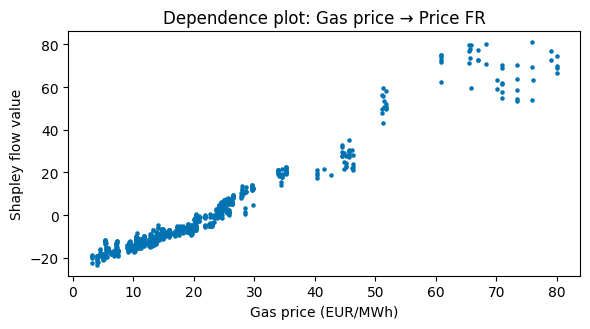

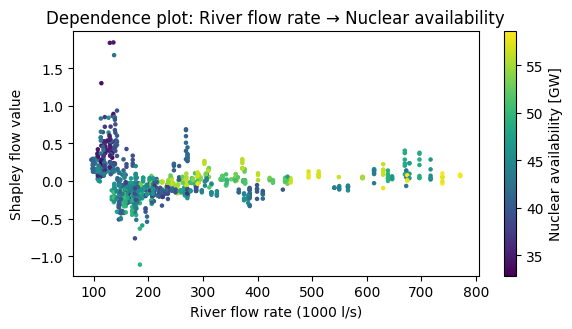

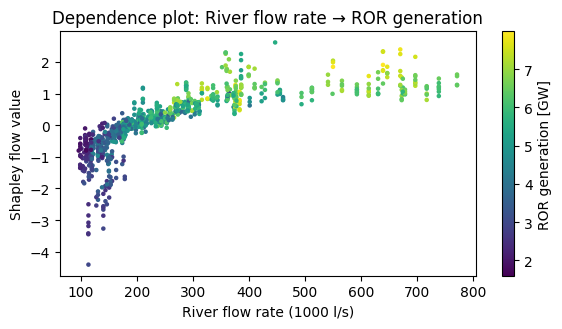

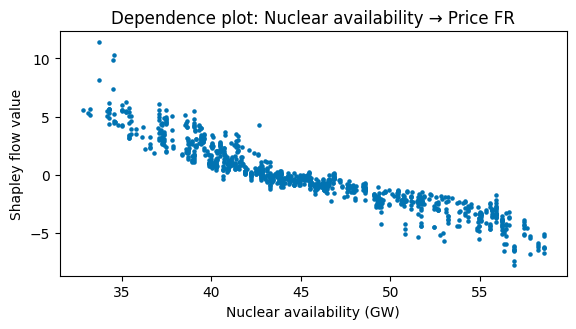

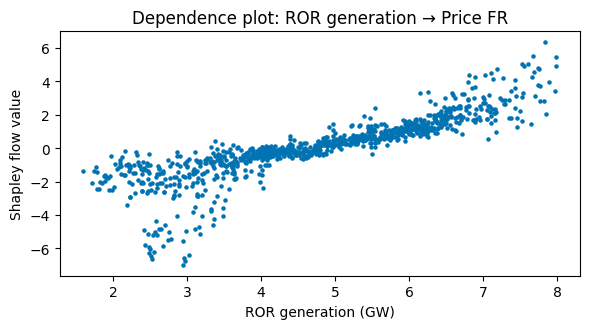

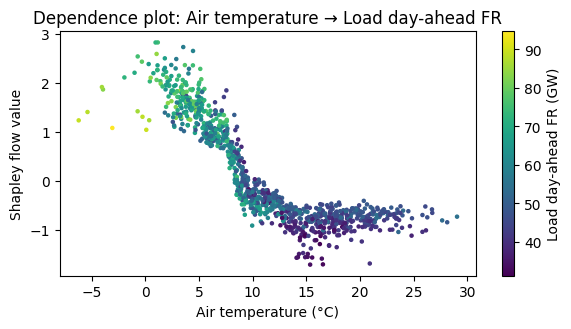

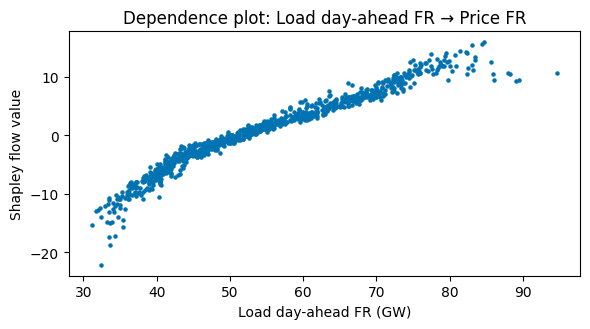

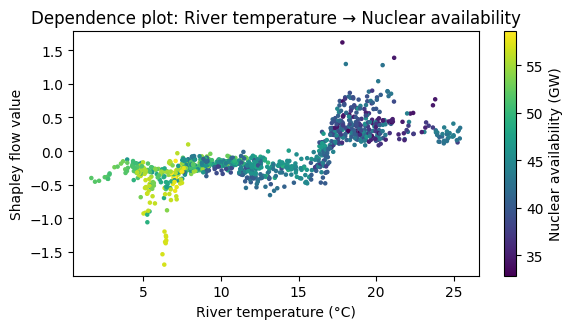

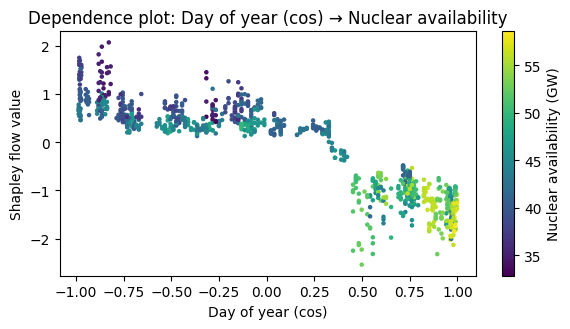

In [89]:
model_index = 0
cf = creditflow_list[model_index]
fg = fg_list[model_index]
start_date, end_date = periods[model_index]
file_name='{}/{}_{}_{}'.format(target, target, start_date, end_date)

plot_dependency_all(target, cf, fg, file_name)

### model 1: October 2021 - December 2023

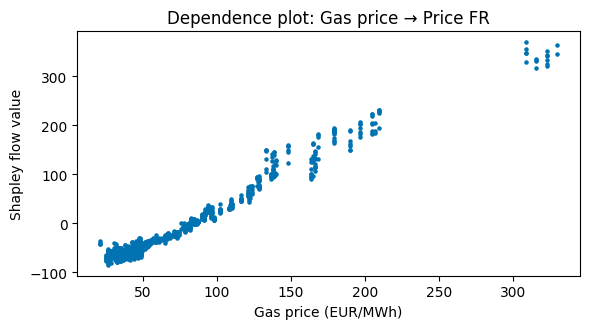

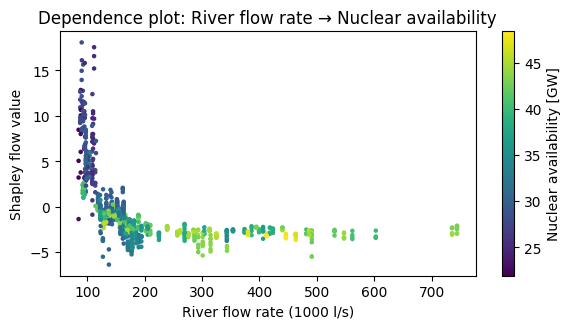

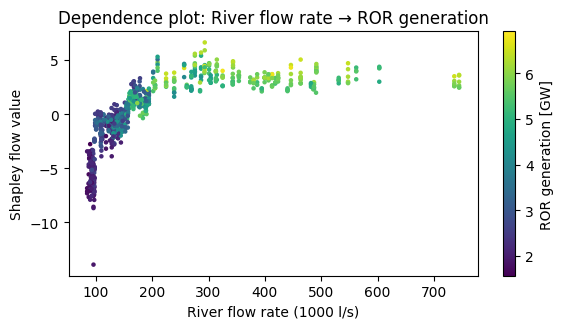

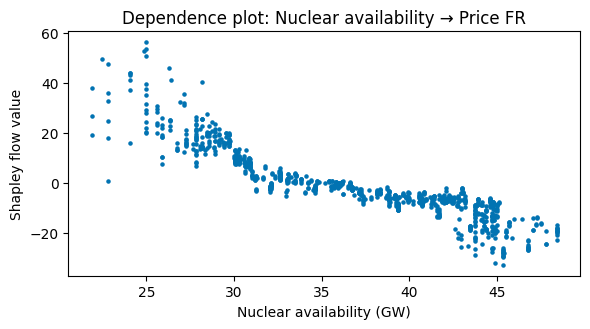

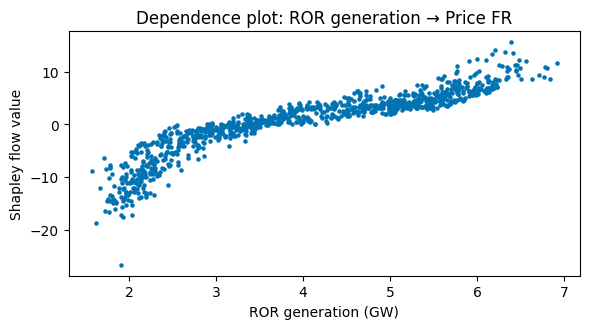

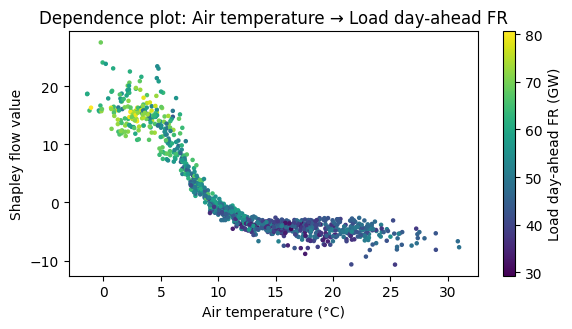

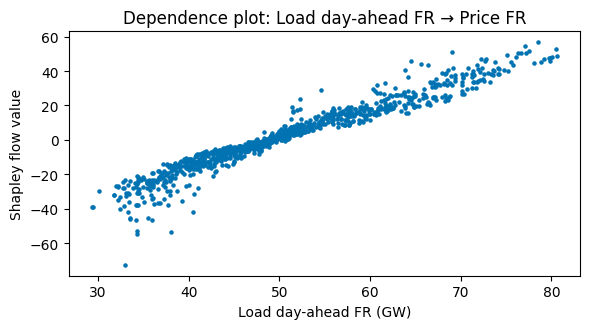

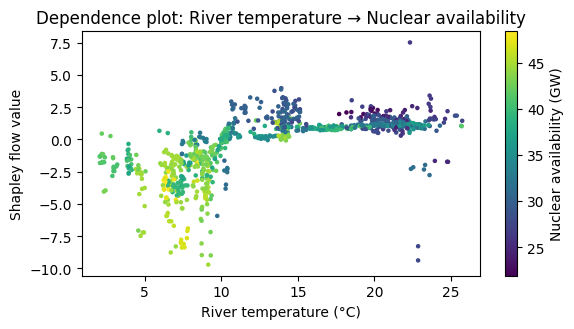

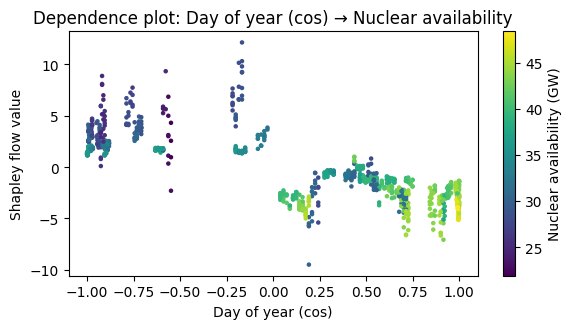

In [90]:
model_index = 1
cf = creditflow_list[model_index]
fg = fg_list[model_index]
start_date, end_date = periods[model_index]
file_name='{}/{}_{}_{}'.format(target, target, start_date, end_date)

plot_dependency_all(target, cf, fg, file_name)

### model 2: January 2018 - December 2023

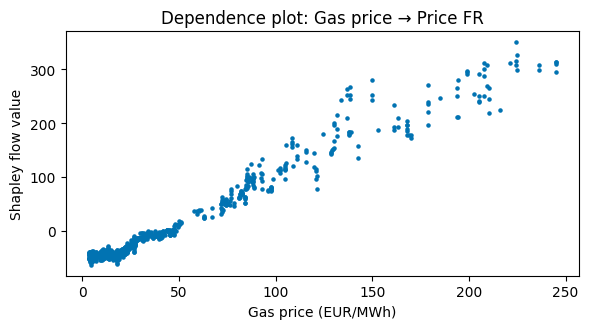

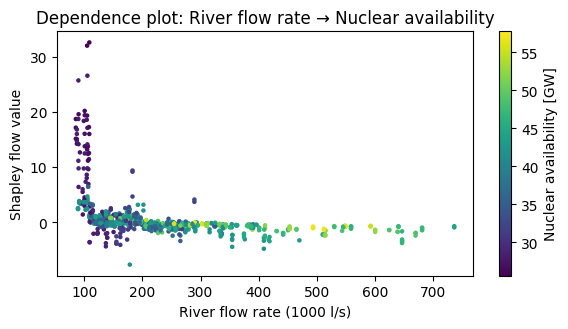

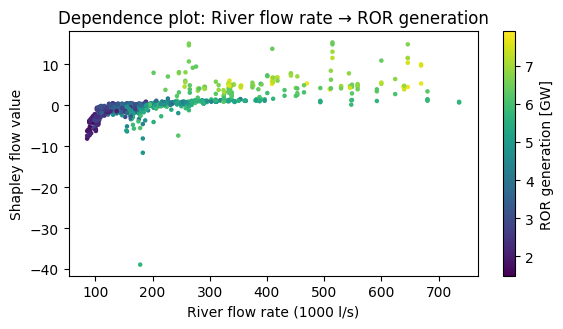

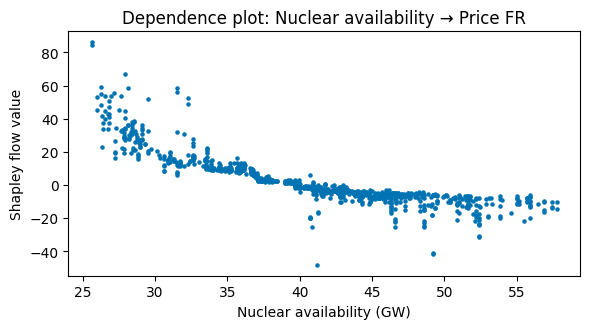

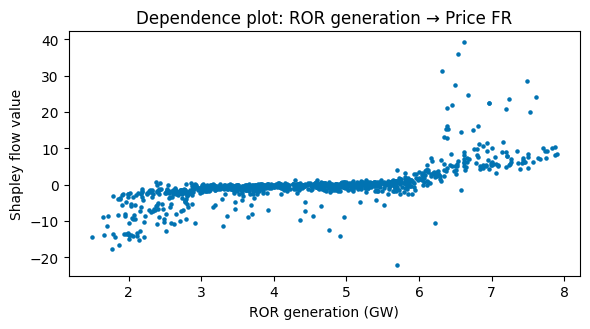

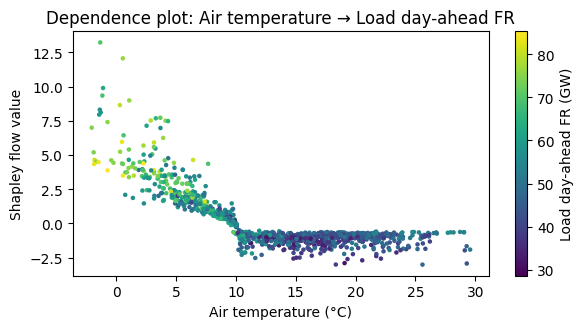

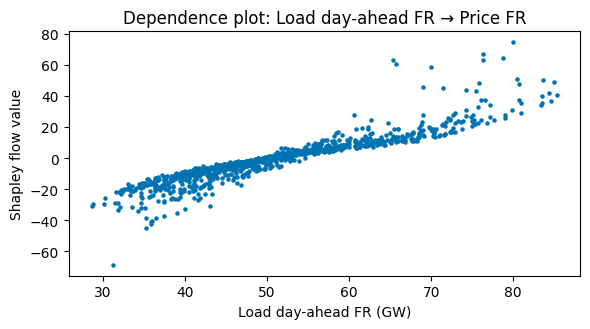

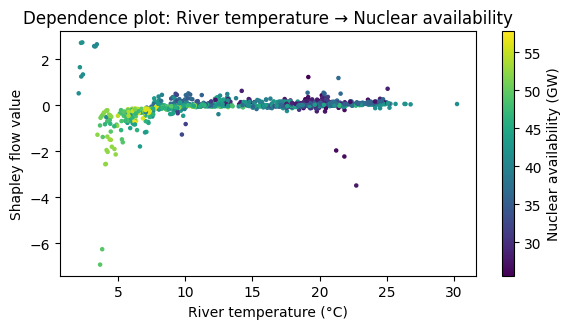

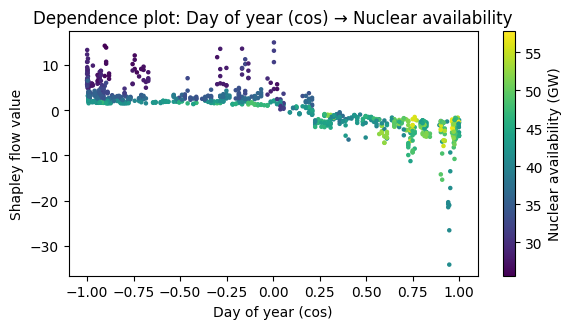

In [91]:
model_index = 2
cf = creditflow_list[model_index]
fg = fg_list[model_index]
start_date, end_date = periods[model_index]
file_name='{}/{}_{}_{}'.format(target, target, start_date, end_date)

plot_dependency_all(target, cf, fg, file_name)

# Tree-SHAP (for reference)

In [92]:
shap_values_list = []
for model_index in range(3):
    model = model_list[model_index]
    fg = fg_list[model_index]
    bg = bg_list[model_index]
    explainer = shap.TreeExplainer(model, data=bg, feature_perturbation='interventional')
    shap_values = explainer.shap_values(fg)
    shap_values_list.append(shap_values)

 95%|=================== | 952/1000 [00:11<00:00]       

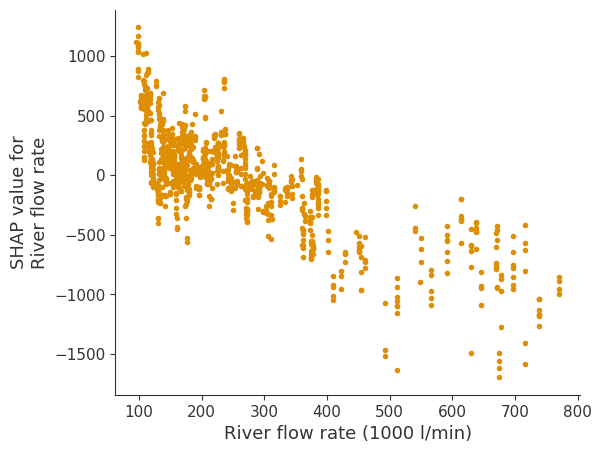

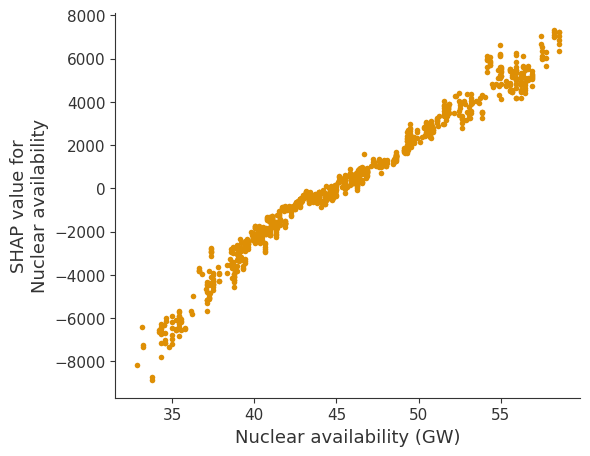

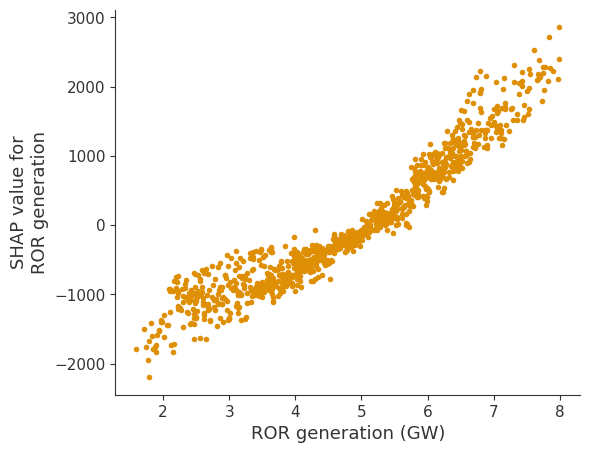

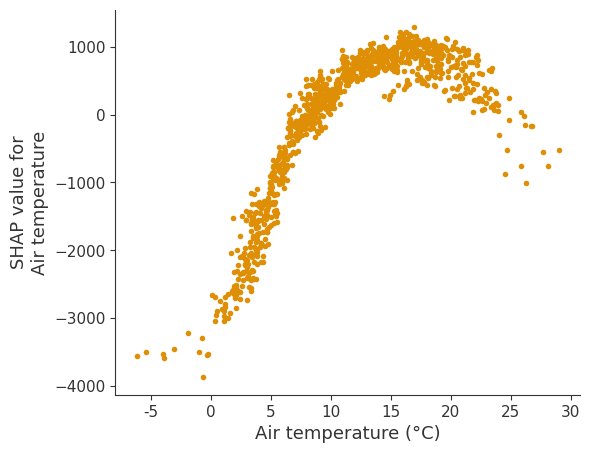

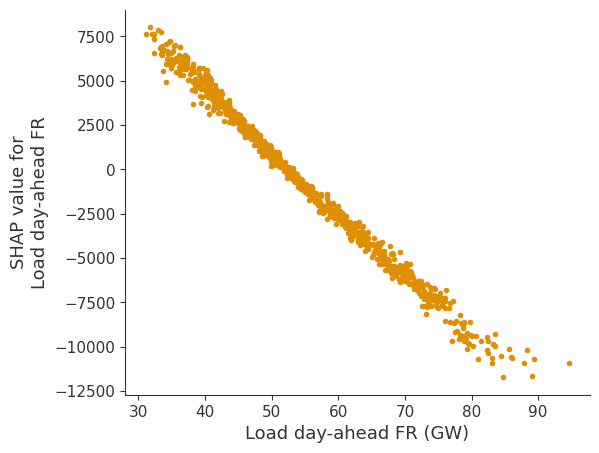

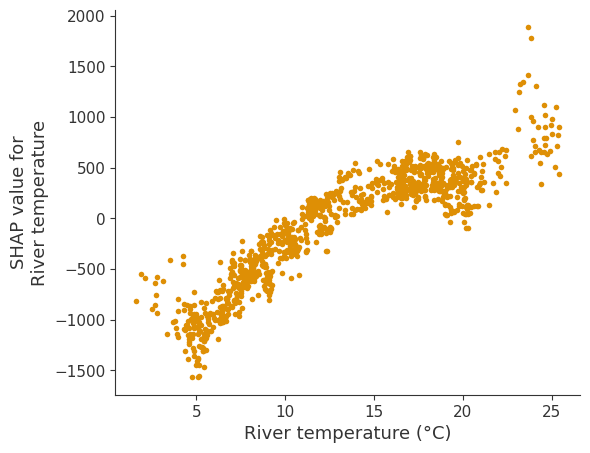

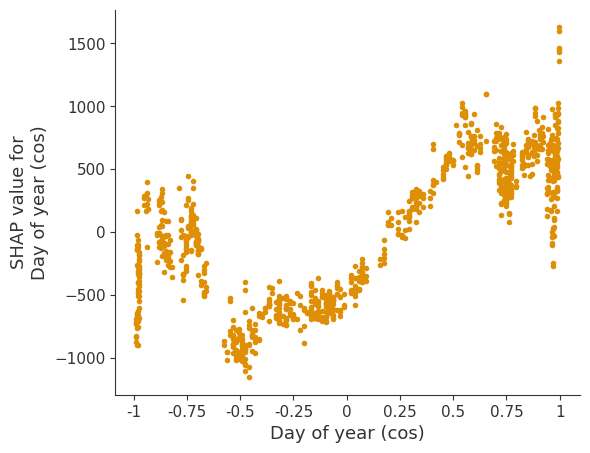

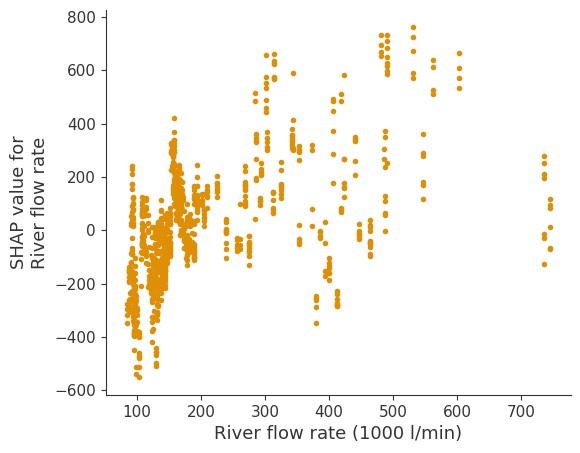

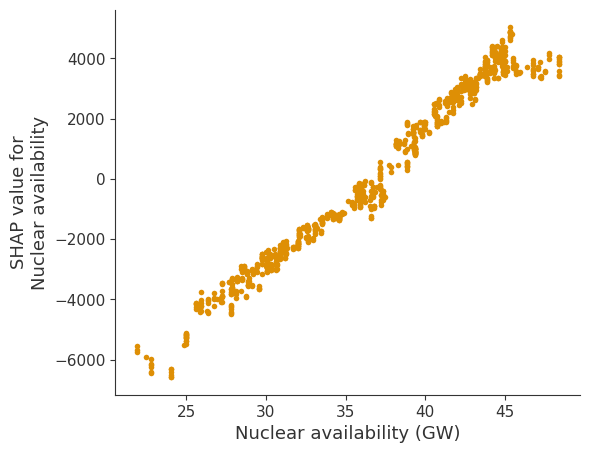

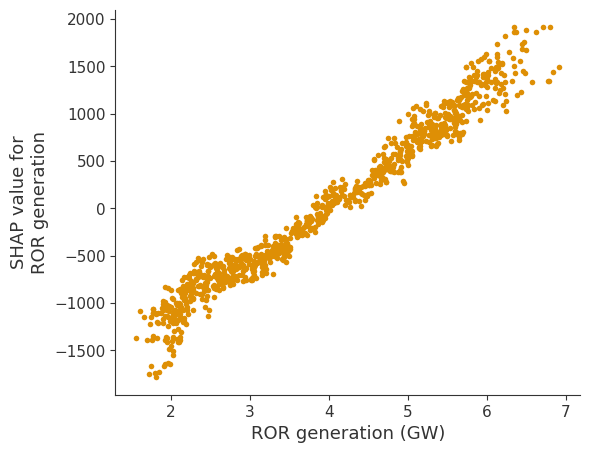

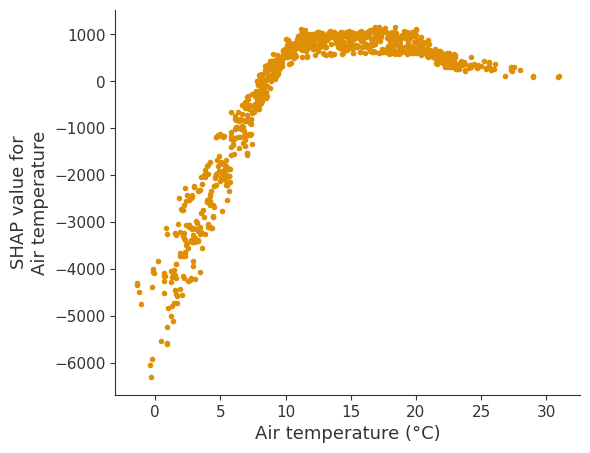

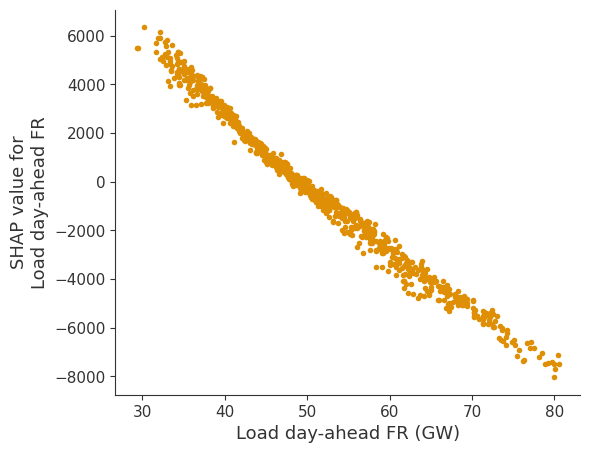

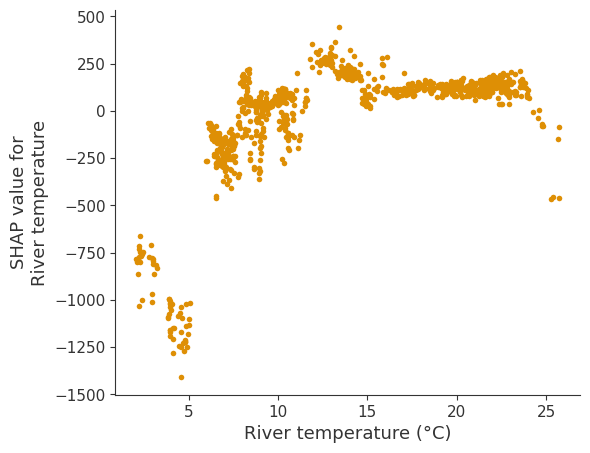

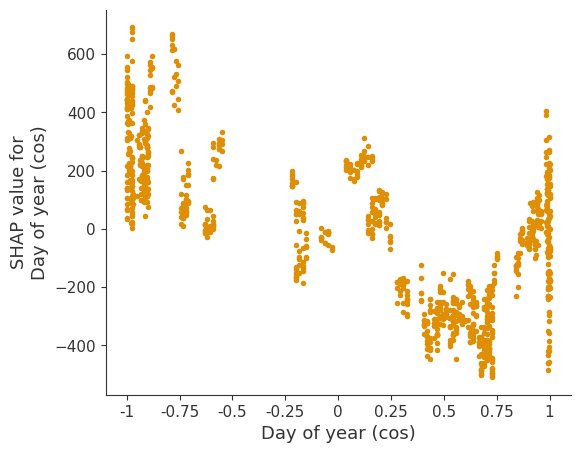

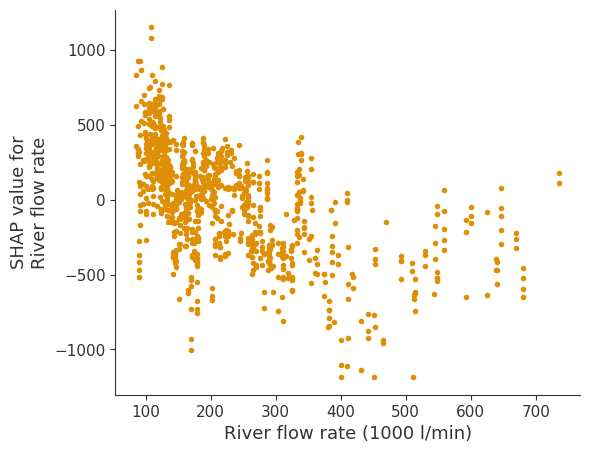

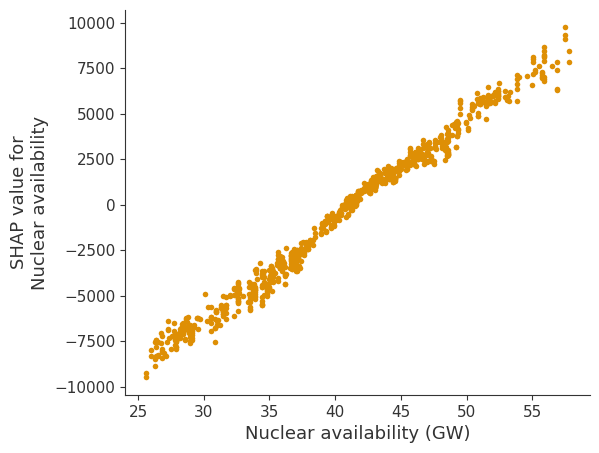

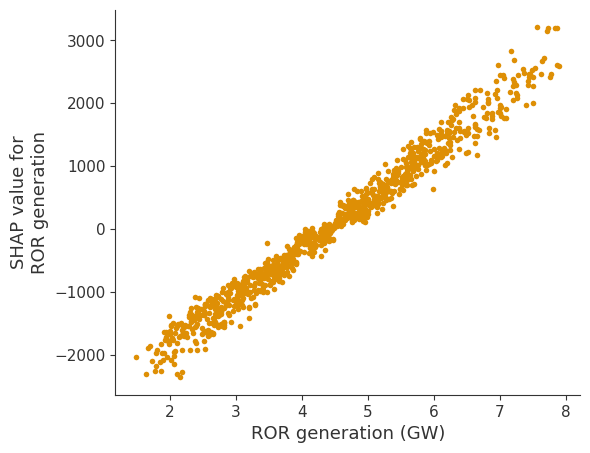

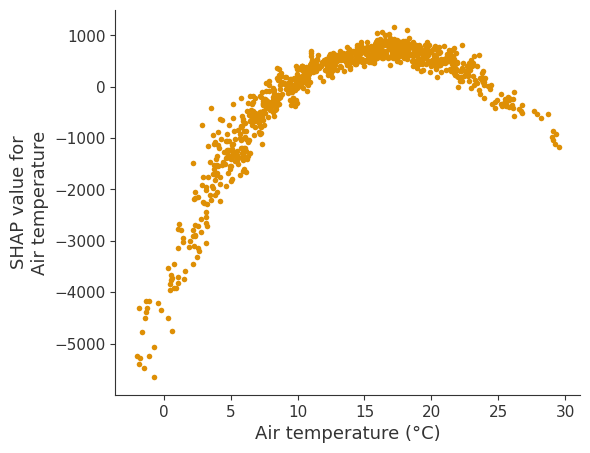

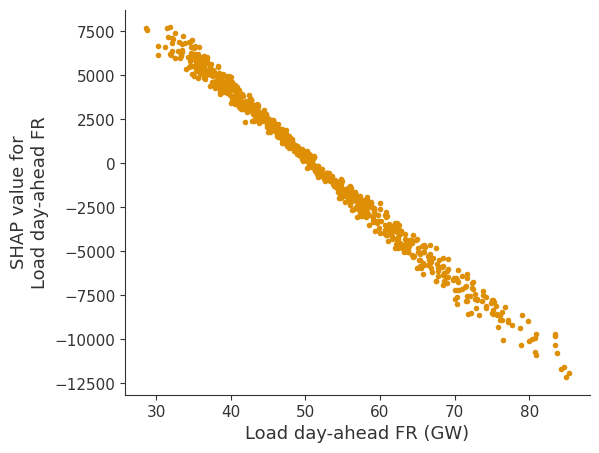

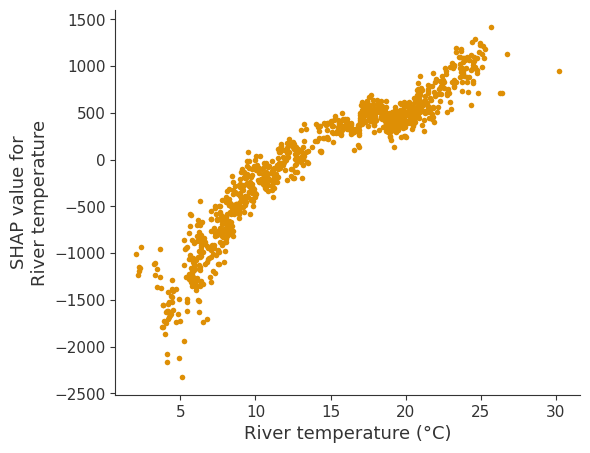

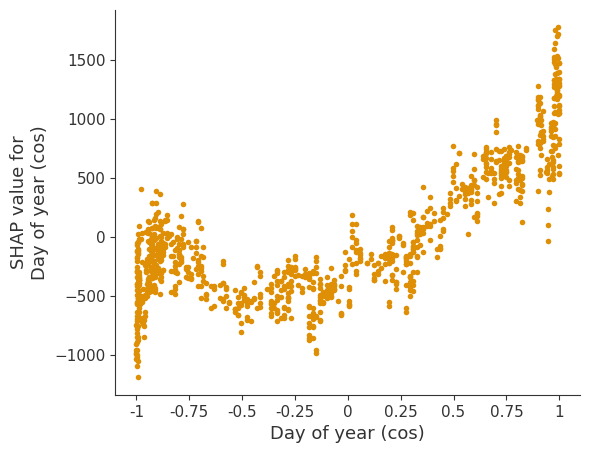

In [95]:
title_dict = {
    'River flow rate': 'River flow rate (1000 l/min)', 
    'Nuclear availability': 'Nuclear availability (GW)', 
    'ROR generation': 'ROR generation (GW)', 
    'Air temperature': 'Air temperature (°C)', 
    'Load day-ahead FR': 'Load day-ahead FR (GW)', 
    'River temperature': 'River temperature (°C)', 
    'Day of year (cos)': 'Day of year (cos)'
}
import matplotlib.ticker as ticker

for i, shap_values in enumerate(shap_values_list):
    for feature in ['River flow rate', 'Nuclear availability', 'ROR generation', 'Air temperature', 'Load day-ahead FR', 'River temperature', 'Day of year (cos)']:
        #shap.summary_plot(shap_values, plot_type='bar', plot_size=(8, 7))
        shap.dependence_plot(feature, shap_values, fg_list[i], interaction_index=None, show=False, color=get_color(target))
        # workaround from https://github.com/shap/shap/issues/594 for x-axis title
        fig, ax = plt.gcf(), plt.gca() 
        ax.set_xlabel(title_dict[feature])
        # workaround for scaling x-axis from https://stackoverflow.com/questions/10171618/changing-plot-scale-by-a-factor-in-matplotlib
        features_to_scale = ['River flow rate', 'Nuclear availability', 'ROR generation', 'Load day-ahead FR']
        if feature in features_to_scale:
            scale_x = 1000
        else:
            scale_x = 1
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
        ax.xaxis.set_major_formatter(ticks_x)

        start_date, end_date = periods[i]
        if i == 0:
            folder_name = '2018-2021'
        elif i == 1:
            folder_name = '2021-2023'
        elif i == 2:
            folder_name = '2018-2023'
        plt.savefig("plots/dependence_plots_treeSHAP/{}/{}/dependence_plot_{}_{}_{}.pdf".format(target, folder_name, feature, start_date, end_date), dpi=600, bbox_inches='tight')
        plt.show()

# Model Evaluation

Note: after executing this part, execute the first cells again before executing cells above here (otherwise side-effects can occur)!

In [96]:
from shap_flow_util import read_csv_incl_timeindex
from pytorch_forecasting.metrics import SMAPE
import torch

models = []
targets = ['price', 'export']
for target in targets:
    print('--------------------------')
    print('target: {}'.format(target))
    print('--------------------------')
    for (start_date, end_date) in periods:
        model = xgb.Booster()
        model_name = '/xgb_{}_start_{}_end_{}_best'.format(target, start_date, end_date, version)
        model.load_model("./models/{}/{}.json".format(version, model_name))
        models.append(model)
        
        X_test = read_csv_incl_timeindex('./data/{}/X_test_xgb_{}_start_{}_end_{}.csv'.format(version, target, start_date, end_date))
        y_test = read_csv_incl_timeindex('./data/{}/y_test_xgb_{}_start_{}_end_{}.csv'.format(version, target, start_date, end_date))

        y_pred = pd.DataFrame(index=y_test.index)
        y_pred['xgb_pred'] = model.predict(xgb.DMatrix(X_test))
        r2_score_xgb = r2_score(y_test, y_pred['xgb_pred'])
        mae_xgb = mean_absolute_error(y_test, y_pred['xgb_pred'])
        mse_xgb = mean_squared_error(y_test, y_pred['xgb_pred'])

        mean_abs_dev = np.mean(np.abs(y_test.iloc[:, 0] - np.mean(y_test.iloc[:, 0])))
        mase_xgb = mae_xgb/mean_abs_dev # use formula for non-timeseries data

        y_pred_tensor = torch.tensor(y_pred['xgb_pred'].values, dtype=torch.float)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)
        smape = SMAPE()
        smape_xgb = smape(y_pred_tensor, y_test_tensor)
        
        print(start_date, end_date)
        print("R2: {:0.2f}".format(r2_score_xgb))
        print("MAE: {:0.2f}".format(mae_xgb))
        print("rmse: {:0.2f}".format(np.sqrt(mse_xgb)))
        print("SMAPE: {:0.2f} (symmetric mean absolute percentage error)".format(smape_xgb.item()))
        print("MASE: {:0.2f} (mean absolute scaled error)".format(mase_xgb))
        print("(mean label: {:0.2f})".format(y_test.iloc[:, 0].mean()))
        print("------------------------------")


--------------------------
target: price
--------------------------
2018-01-01 2021-09-30
R2: 0.92
MAE: 5.18
rmse: 9.27
SMAPE: 0.56 (symmetric mean absolute percentage error)
MASE: 0.23 (mean absolute scaled error)
(mean label: 53.52)
------------------------------
2021-10-01 2023-12-31
R2: 0.82
MAE: 21.89
rmse: 63.56
SMAPE: 0.74 (symmetric mean absolute percentage error)
MASE: 0.21 (mean absolute scaled error)
(mean label: 184.90)
------------------------------
2018-01-01 2023-12-31
R2: 0.96
MAE: 12.48
rmse: 22.96
SMAPE: 1.27 (symmetric mean absolute percentage error)
MASE: 0.15 (mean absolute scaled error)
(mean label: 107.04)
------------------------------
--------------------------
target: export
--------------------------
2018-01-01 2021-09-30
R2: 0.87
MAE: 1297.78
rmse: 1683.27
SMAPE: 0.64 (symmetric mean absolute percentage error)
MASE: 0.35 (mean absolute scaled error)
(mean label: 5907.20)
------------------------------
2021-10-01 2023-12-31
R2: 0.92
MAE: 1383.83
rmse: 1765.20